In [2]:
from glob import glob
from pathlib import Path
import sys
sys.path.append("../")

from jax import numpy as jnp
from jax import Array
import h5py

In [5]:
paths = {"Lorenz Attractor": "../results/lorenz/dt__*.h5", "Van der Pol Oscillator": "../results/vanderpol/dt__*.h5"}
adaptive_paths = {"Lorenz Attractor": "../results/lorenz/dt_adaptive.h5", "Van der Pol Oscillator": "../results/vanderpol/dt_adaptive.h5"}

results = {k: {float(Path(file).name.removeprefix("dt__").removesuffix(".h5").replace("_", ".")): h5py.File(file) for file in glob(path)} for k, path in paths.items()}
adaptive_results = {k: h5py.File(file) for k, file in adaptive_paths.items()}

In [6]:
from matplotlib import pyplot as plt
from matplotlib.ticker import LogFormatterExponent
from matplotlib.lines import Line2D
from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
colors_eps = [rgb.tue_red, rgb.tue_blue, rgb.tue_green]
color_const = rgb.tue_gold
color_true = rgb.tue_dark

In [8]:
def closest_t_indices(reference: Array, test: Array) -> Array:
    # https://stackoverflow.com/a/20785149
    
    idx1 = jnp.searchsorted(reference, test)
    idx2 = jnp.clip(idx1 - 1, 0, len(reference) - 1)

    diff1 = reference[idx1] - test
    diff2 = test - reference[idx2]

    return jnp.where(diff1 <= diff2, idx1, idx2)

In [25]:
from matplotlib.patches import Path, PathPatch
import numpy as np

def draw_error_band(ax, x, y, err, **kwargs):
    # cf. https://matplotlib.org/stable/gallery/lines_bars_and_markers/curve_error_band.html
    
    dx = jnp.concatenate([(x[1] - x[0])[None], x[2:] - x[:-2], (x[-1] - x[-2])[None]])
    dy = jnp.concatenate([(y[1] - y[0])[None], y[2:] - y[:-2], (y[-1] - y[-2])[None]])
    l = jnp.hypot(dx, dy)
    nx = dy / l
    ny = -dx / l

    # end points of errors
    xp = x + nx * err
    yp = y + ny * err
    xn = x - nx * err
    yn = y - ny * err

    vertices = jnp.block([[xp, xn[::-1]],
                         [yp, yn[::-1]]]).T
    codes = np.full(len(vertices), Path.LINETO)
    codes[0] = codes[len(xp)] = Path.MOVETO
    path = Path(vertices, jnp.asarray(codes))
    ax.add_patch(PathPatch(path, **kwargs))

# Fixed Step Size

## Van-der-Pol Oscillator

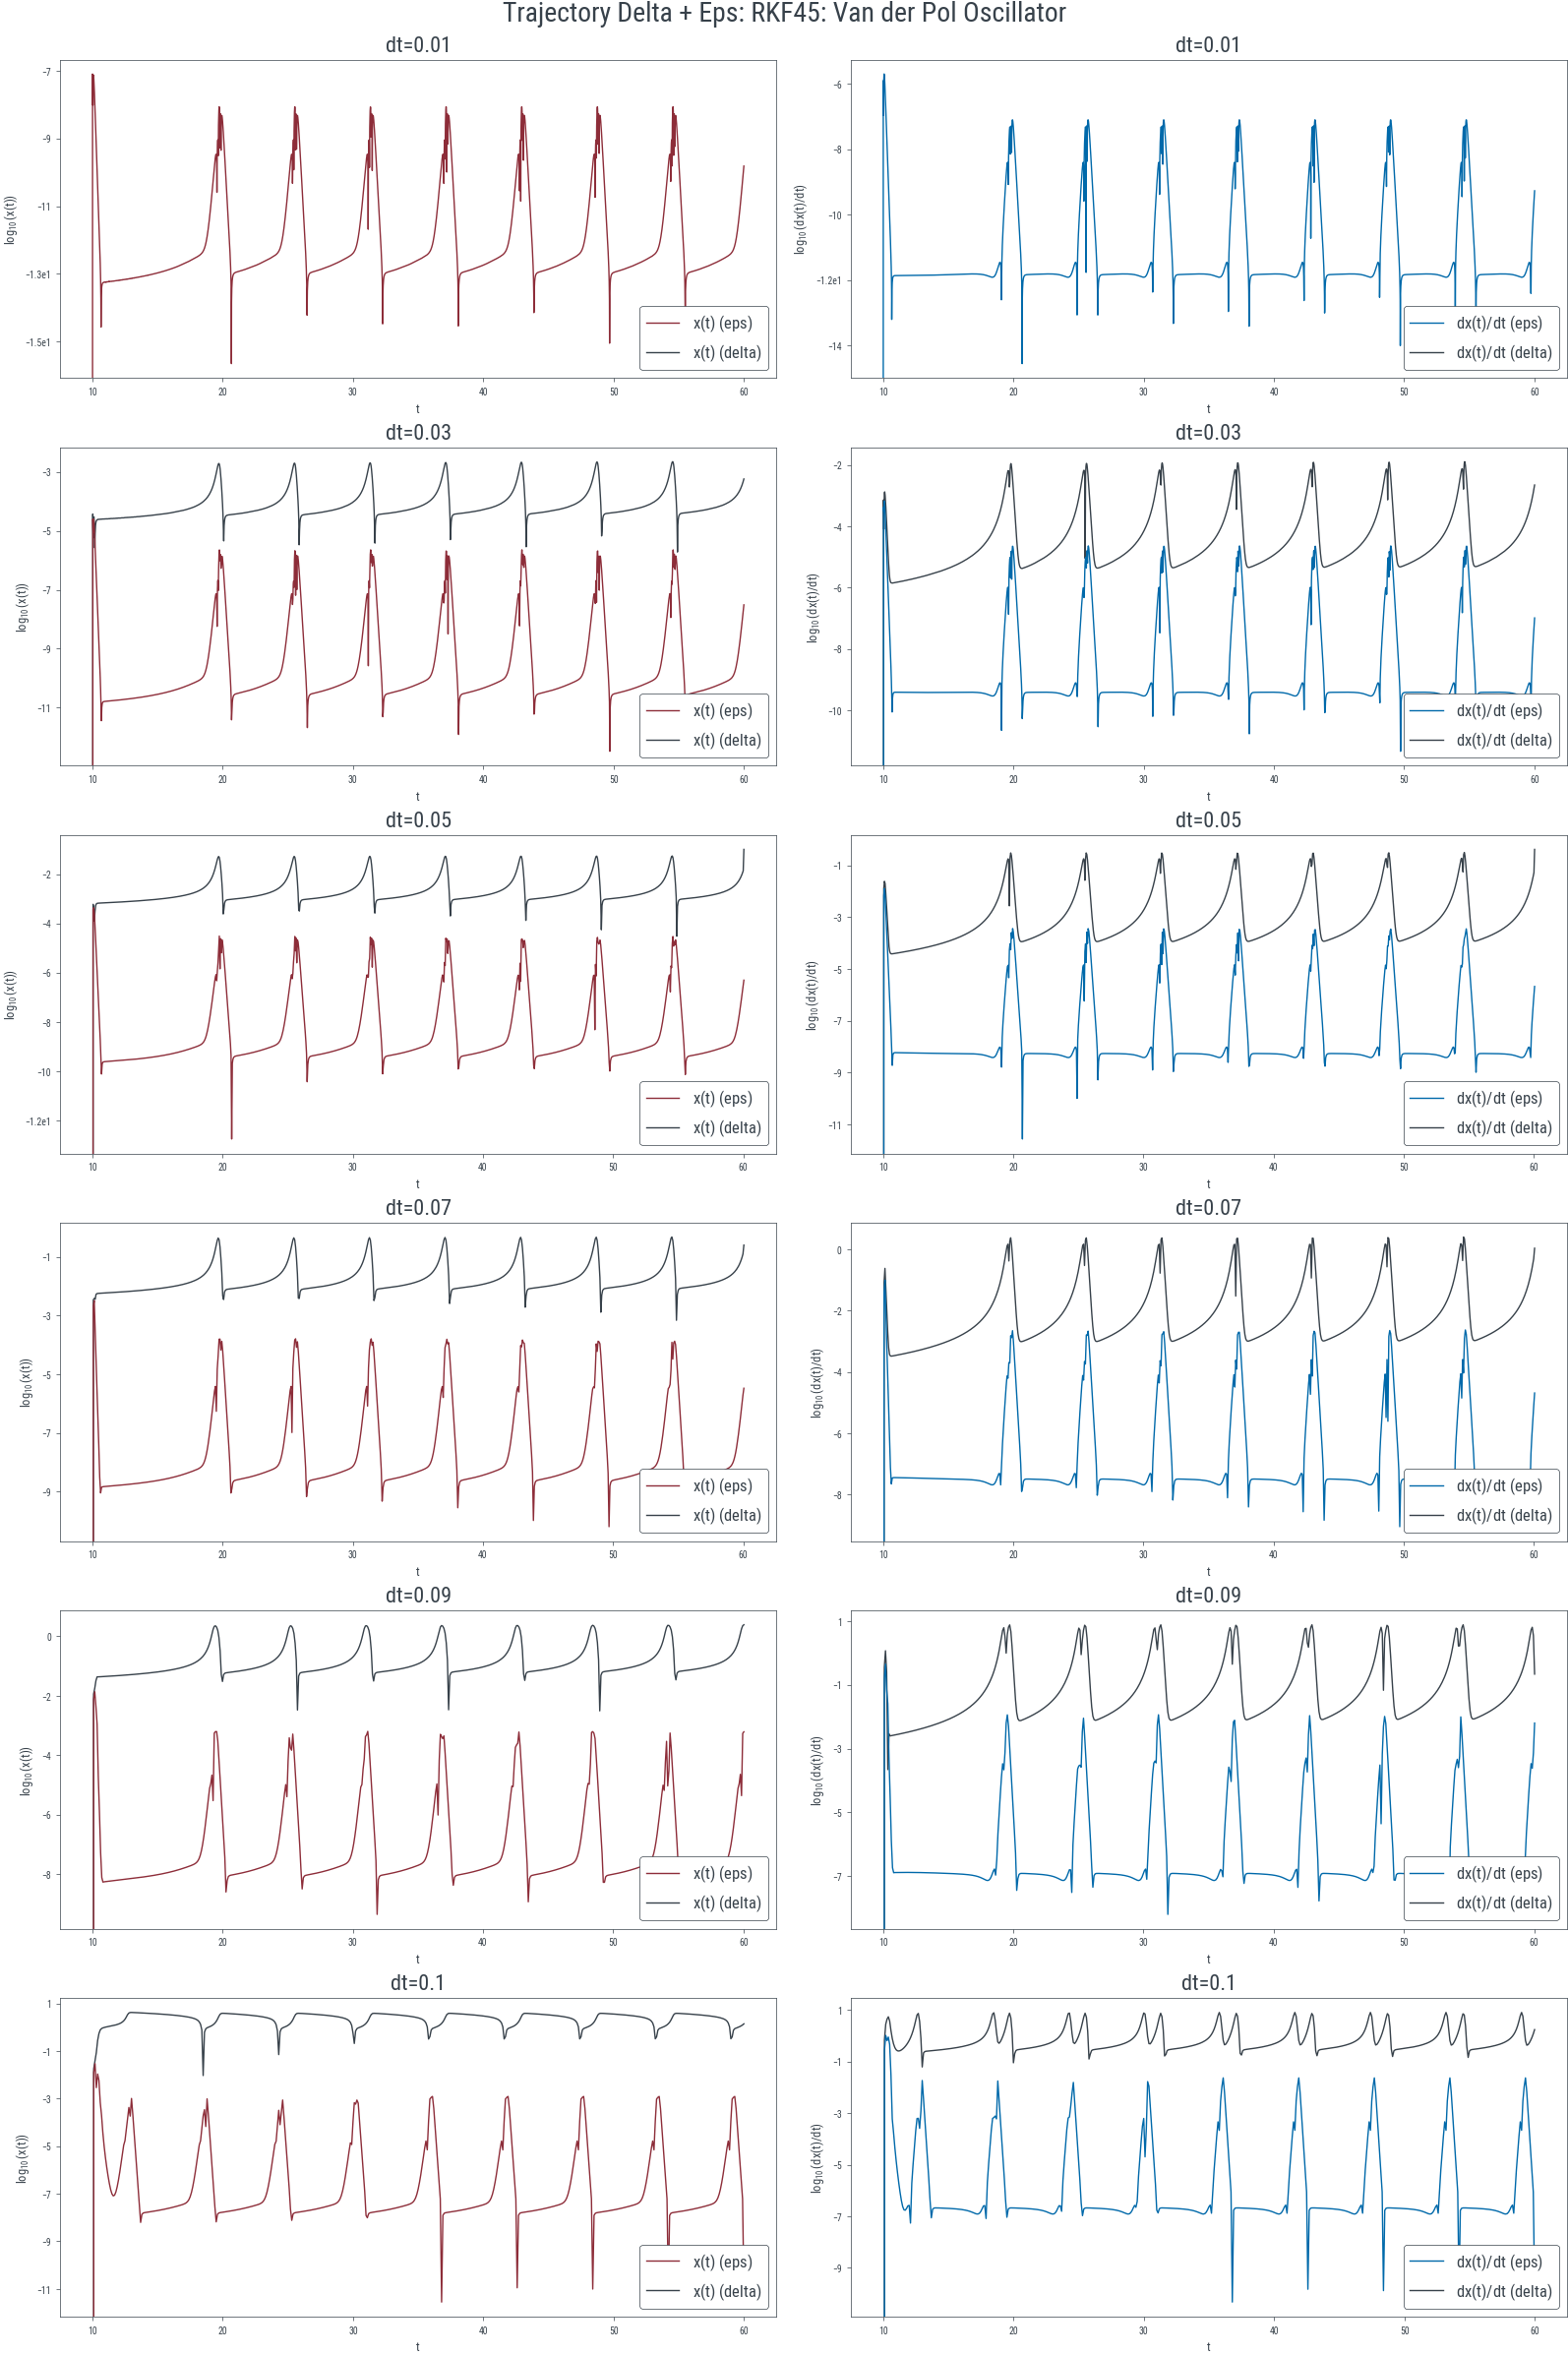

In [11]:
ode_name = "Van der Pol Oscillator"
C = 2
r = results[ode_name]
min_dt = min(r.keys())
dts_sorted = sorted(r.keys())

def fn_label(idx):
    if idx > 1:
        return f"$d^{idx+1}x(t)/dt^{idx+1}$"
    elif idx == 1:
        return f"$dx(t)/dt$"
    else:
        return f"$x(t)$"

fig, axs = plt.subplots(len(r), C, figsize=(C*8, len(r)*4))
ts_true, xs_true = jnp.asarray(r[min_dt]["t"]), jnp.asarray(r[min_dt]["x"])
for row, dt in enumerate(dts_sorted):
    ts, xs, eps = jnp.asarray(r[dt]["t"]), jnp.asarray(r[dt]["x"]), jnp.asarray(r[dt]["eps"])
    for col in range(C):
        ax = axs[row, col]
        t_indices = closest_t_indices(ts_true, ts)
        ts_true_cap, xs_true_cap = ts_true[t_indices], xs_true[t_indices]
        delta = jnp.abs(xs_true_cap[:, col, 0] - xs[:, col, 0])
            
        ax.plot(ts, delta, color=color_true)
        ax.plot(ts, eps[:, col, 0], color=colors_eps[col])
        #ax.plot(ts, 1e4*dt**2 * eps[:, col, 0]**0.5, color=colors_eps[col])
        ax.set_yscale("log")
        ax.get_yaxis().set_major_formatter(LogFormatterExponent(base=10, labelOnlyBase=True))
        ax.set_xlabel("$t$")
        ax.set_ylabel("$\\log_{10}(" + fn_label(col).removeprefix("$").removesuffix("$") + ")$")
        
        handles = [Line2D([0], [0], label=fn_label(col) + " (eps)", color=colors_eps[col]),
                    Line2D([0], [0], label=fn_label(col) + " (delta)", color=color_true)]
        ax.set_title(f"dt={dt}", fontsize=16)
        ax.legend(handles=handles, fontsize=12, loc="lower right", facecolor='white', framealpha=1)
fig.suptitle(f"Trajectory Delta + Eps: RKF45: {ode_name}", fontsize=20);

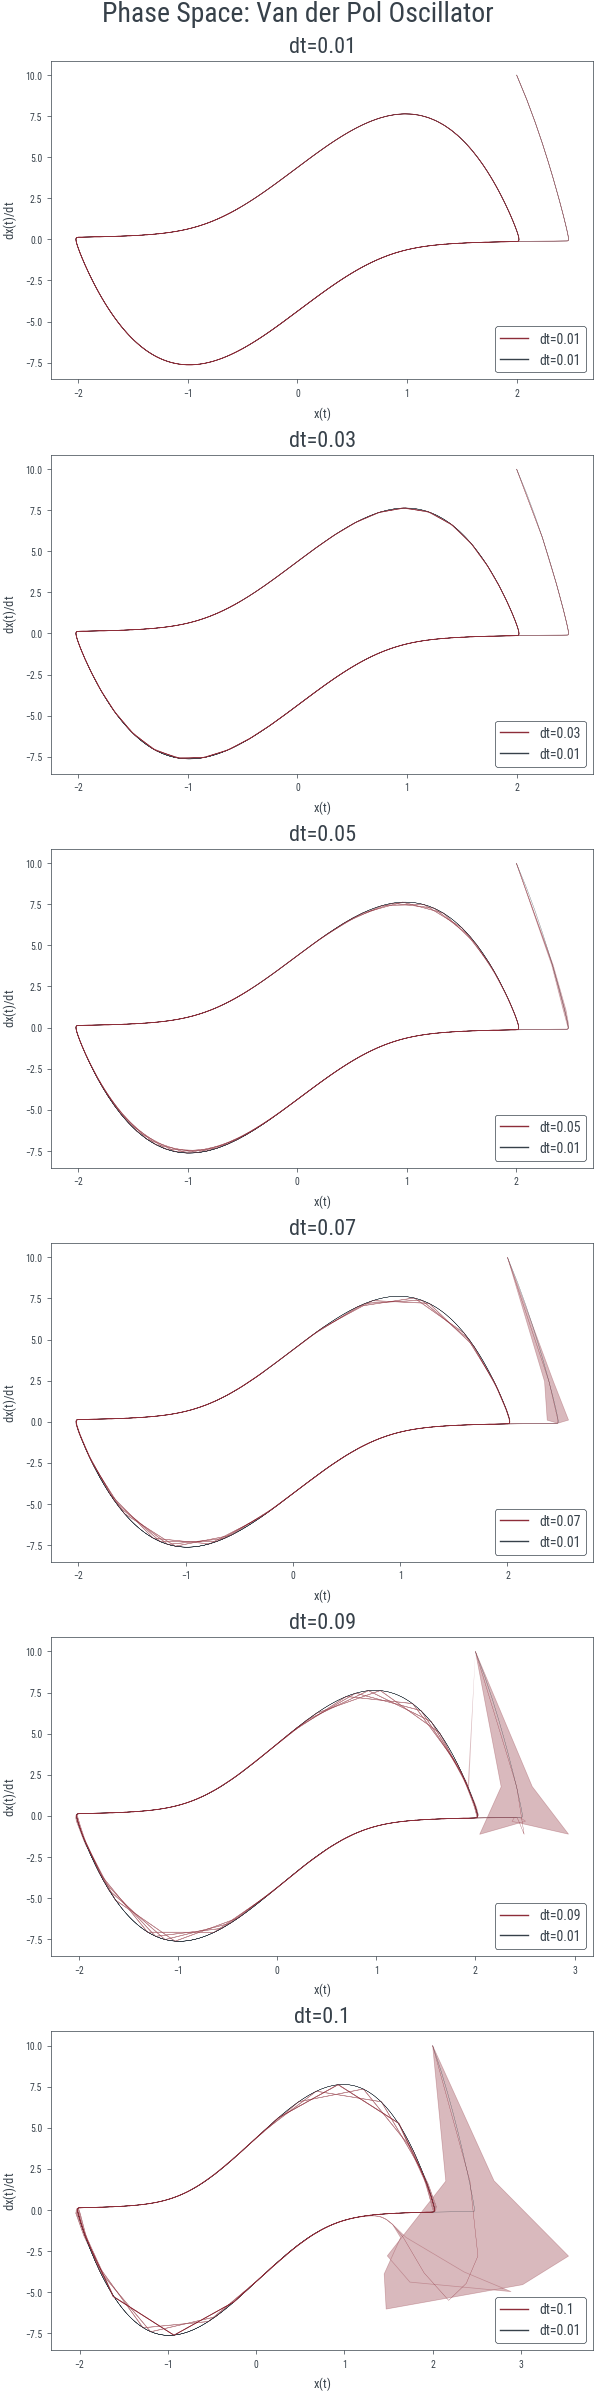

In [31]:
ode_name = "Van der Pol Oscillator"
C = 2
r = results[ode_name]
min_dt = min(r.keys())
dts_sorted = sorted(r.keys())

fig, axs = plt.subplots(len(r), 1, figsize=(6, len(r)*4))
xs_true = jnp.asarray(r[min_dt]["x"])
for row, dt in enumerate(dts_sorted):
    xs, eps = jnp.asarray(r[dt]["x"]), jnp.asarray(r[dt]["eps"])
    ax = axs[row]
    ax.plot(xs_true[:, 0, 0], xs_true[:, 1, 0], color=color_true, linewidth=0.2)
    ax.plot(xs[:, 0, 0], xs[:, 1, 0], color=colors_eps[0], linewidth=0.2)
    draw_error_band(ax, xs[:, 0, 0], xs[:, 1, 0], (eps[:, 0, 0]**2 + eps[:, 1, 0]**2)**0.5, color=colors_eps[0], alpha=0.33)
    handles = [Line2D([0], [0], label=f"dt={dt}", color=colors_eps[0]),
                Line2D([0], [0], label=f"dt={min_dt}", color=color_true)]
    ax.set_title(f"dt={dt}", fontsize=16)
    ax.legend(handles=handles, fontsize=10, loc="lower right", facecolor='white', framealpha=1)
    ax.set_xlabel("$x(t)$")
    ax.set_ylabel("$dx(t)/dt$")
fig.suptitle(f"Phase Space: {ode_name}", fontsize=20);

## Lorenz Attractor

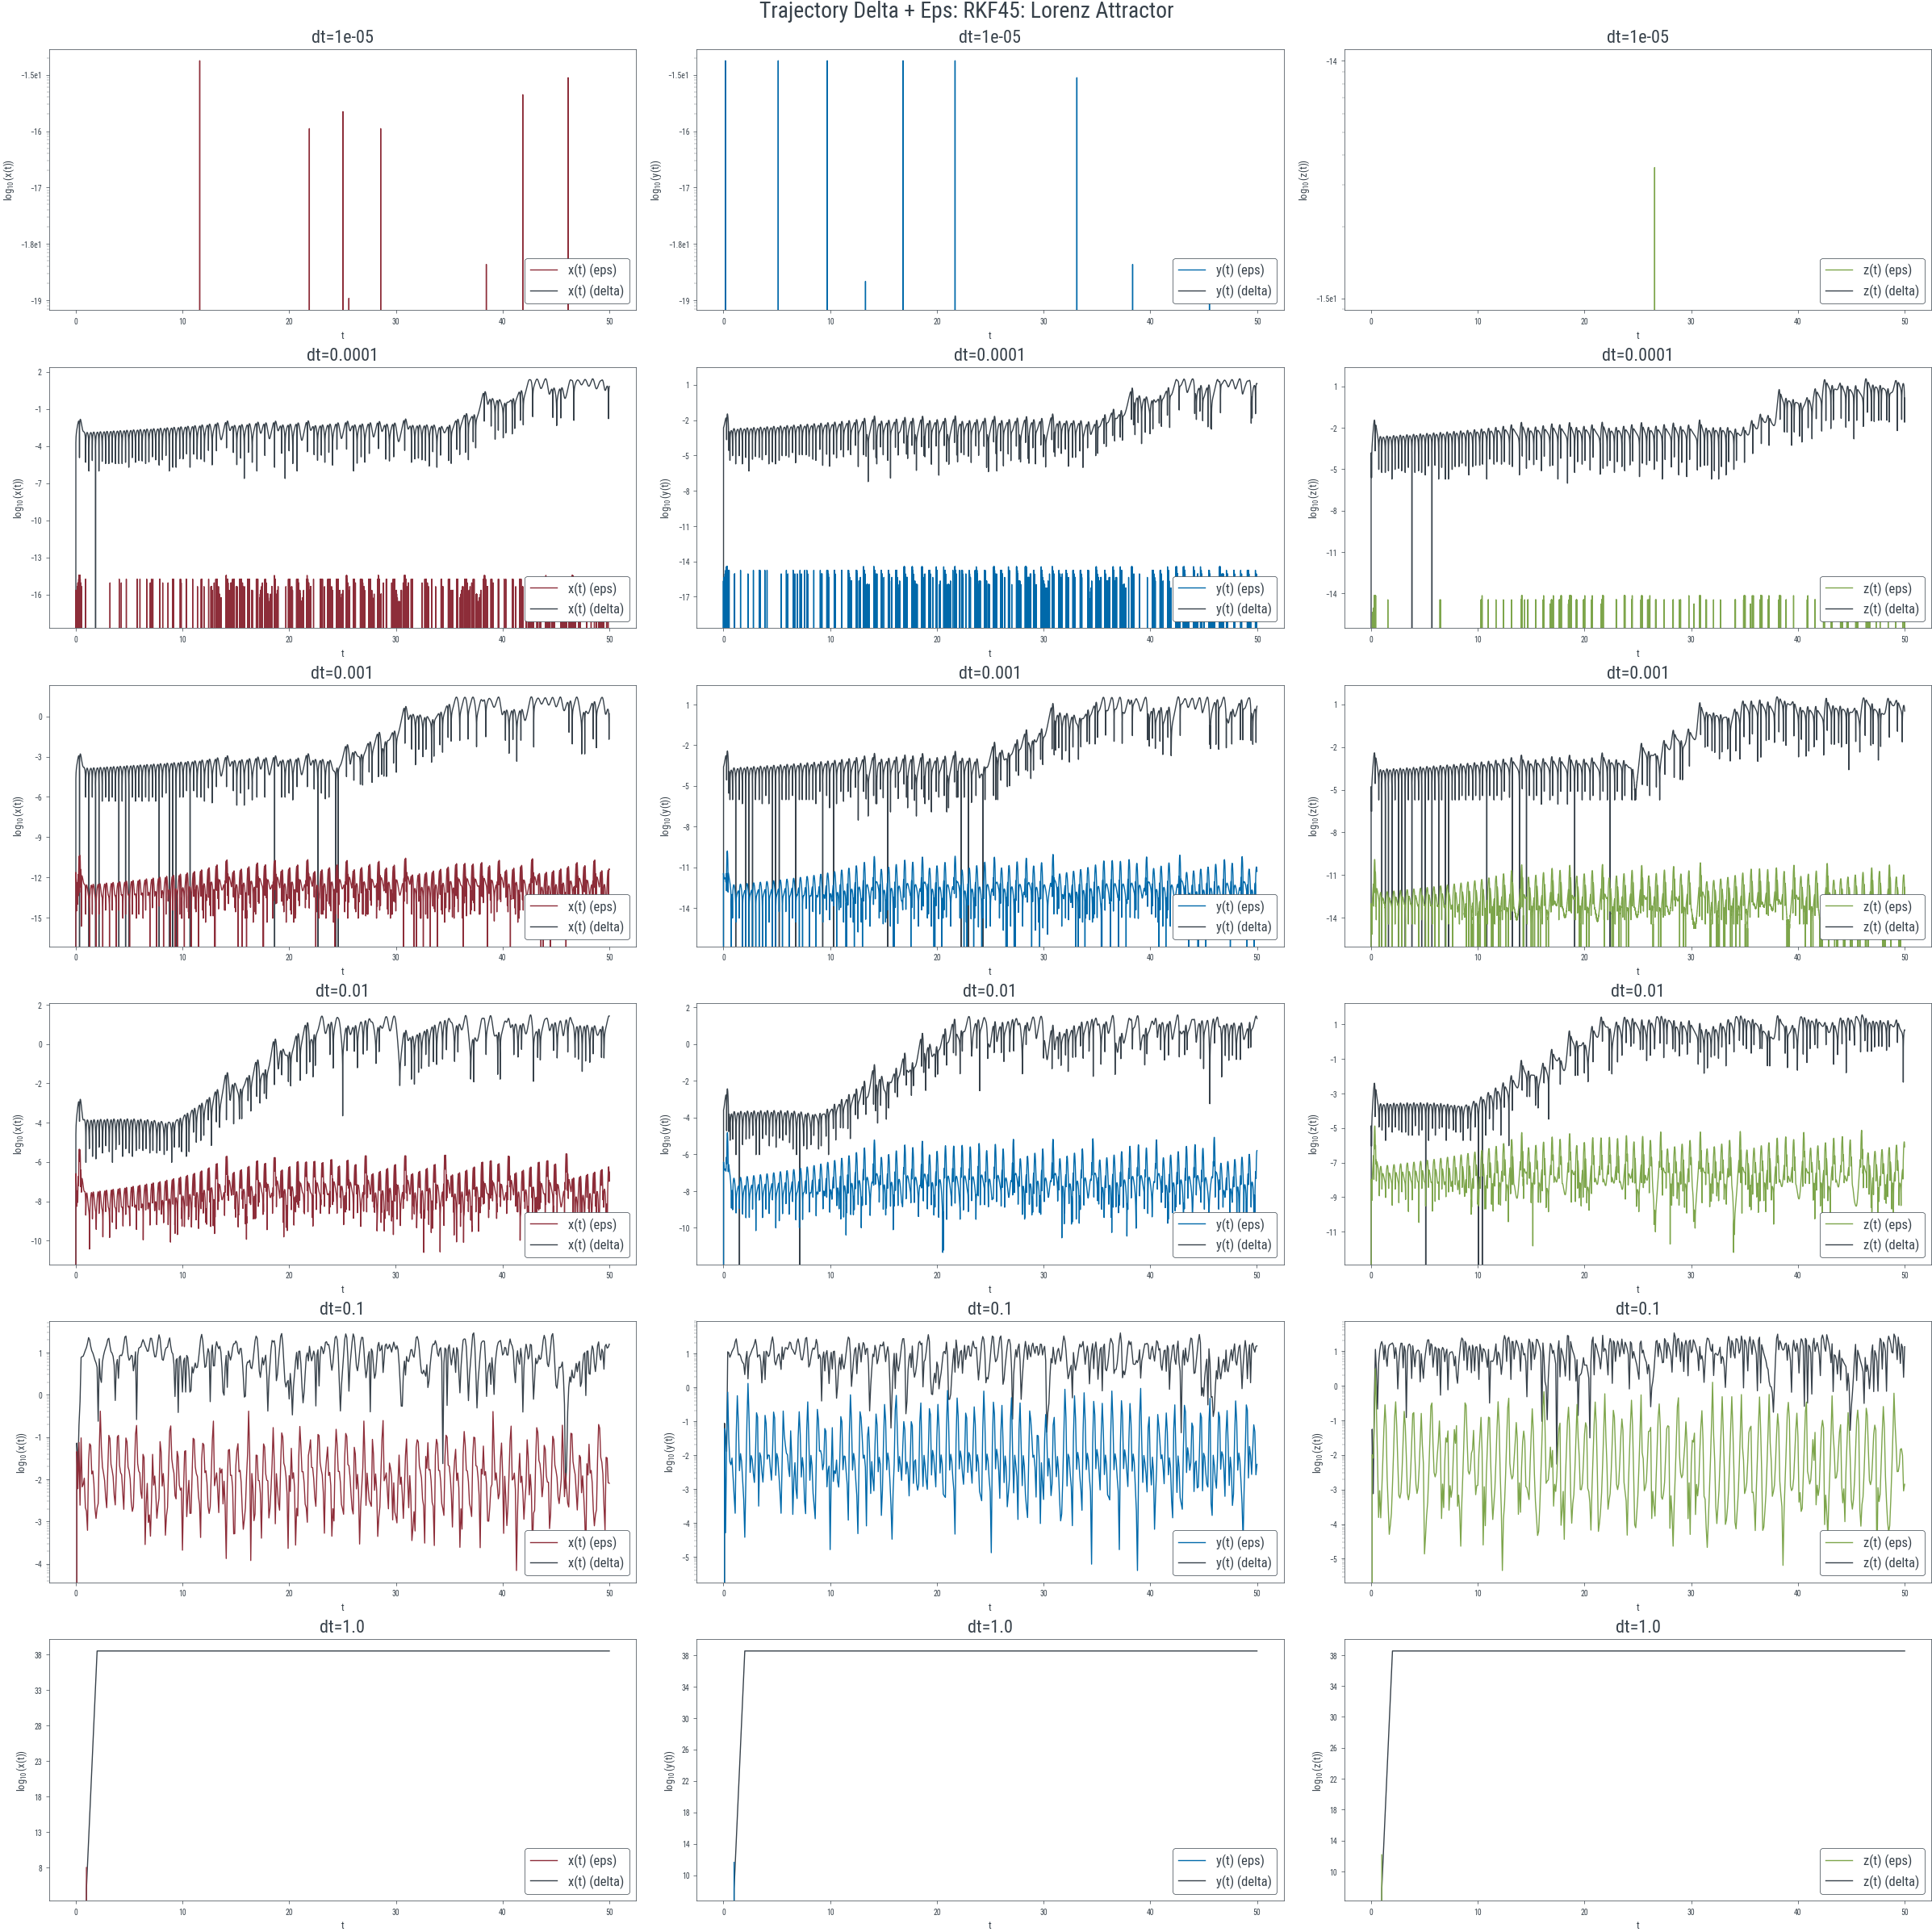

In [47]:
ode_name = "Lorenz Attractor"
C = 3
r = results[ode_name]
min_dt = min(r.keys())
dts_sorted = sorted(r.keys())

def fn_label(idx):
    map_idx = {0: "x", 1: "y", 2: "z"}
    return f"{map_idx[idx]}(t)"

fig, axs = plt.subplots(len(r), C, figsize=(C*8, len(r)*4))
ts_true, xs_true = jnp.asarray(r[min_dt]["t"]), jnp.asarray(r[min_dt]["x"])
for row, dt in enumerate(dts_sorted):
    ts, xs, eps = jnp.asarray(r[dt]["t"]), jnp.asarray(r[dt]["x"]), jnp.asarray(r[dt]["eps"])
    for col in range(C):
        ax = axs[row, col]
        t_indices = closest_t_indices(ts_true, ts)
        ts_true_cap, xs_true_cap = ts_true[t_indices], xs_true[t_indices]
        delta = jnp.nan_to_num(jnp.abs(xs_true_cap[:, 0, col] - xs[:, 0, col]), nan=jnp.inf)
            
        ax.plot(ts, delta, color=color_true)
        ax.plot(ts, eps[:, 0, col], color=colors_eps[col])
        #ax.plot(ts, 1e4*dt**2 * eps[:, col, 0]**0.5, color=colors_eps[col])
        ax.set_yscale("log")
        ax.get_yaxis().set_major_formatter(LogFormatterExponent(base=10, labelOnlyBase=True))
        ax.set_xlabel("$t$")
        ax.set_ylabel("$\\log_{10}(" + fn_label(col).removeprefix("$").removesuffix("$") + ")$")
        
        handles = [Line2D([0], [0], label=fn_label(col) + " (eps)", color=colors_eps[col]),
                    Line2D([0], [0], label=fn_label(col) + " (delta)", color=color_true)]
        ax.set_title(f"dt={dt}", fontsize=16)
        ax.legend(handles=handles, fontsize=12, loc="lower right", facecolor='white', framealpha=1)
fig.suptitle(f"Trajectory Delta + Eps: RKF45: {ode_name}", fontsize=20);

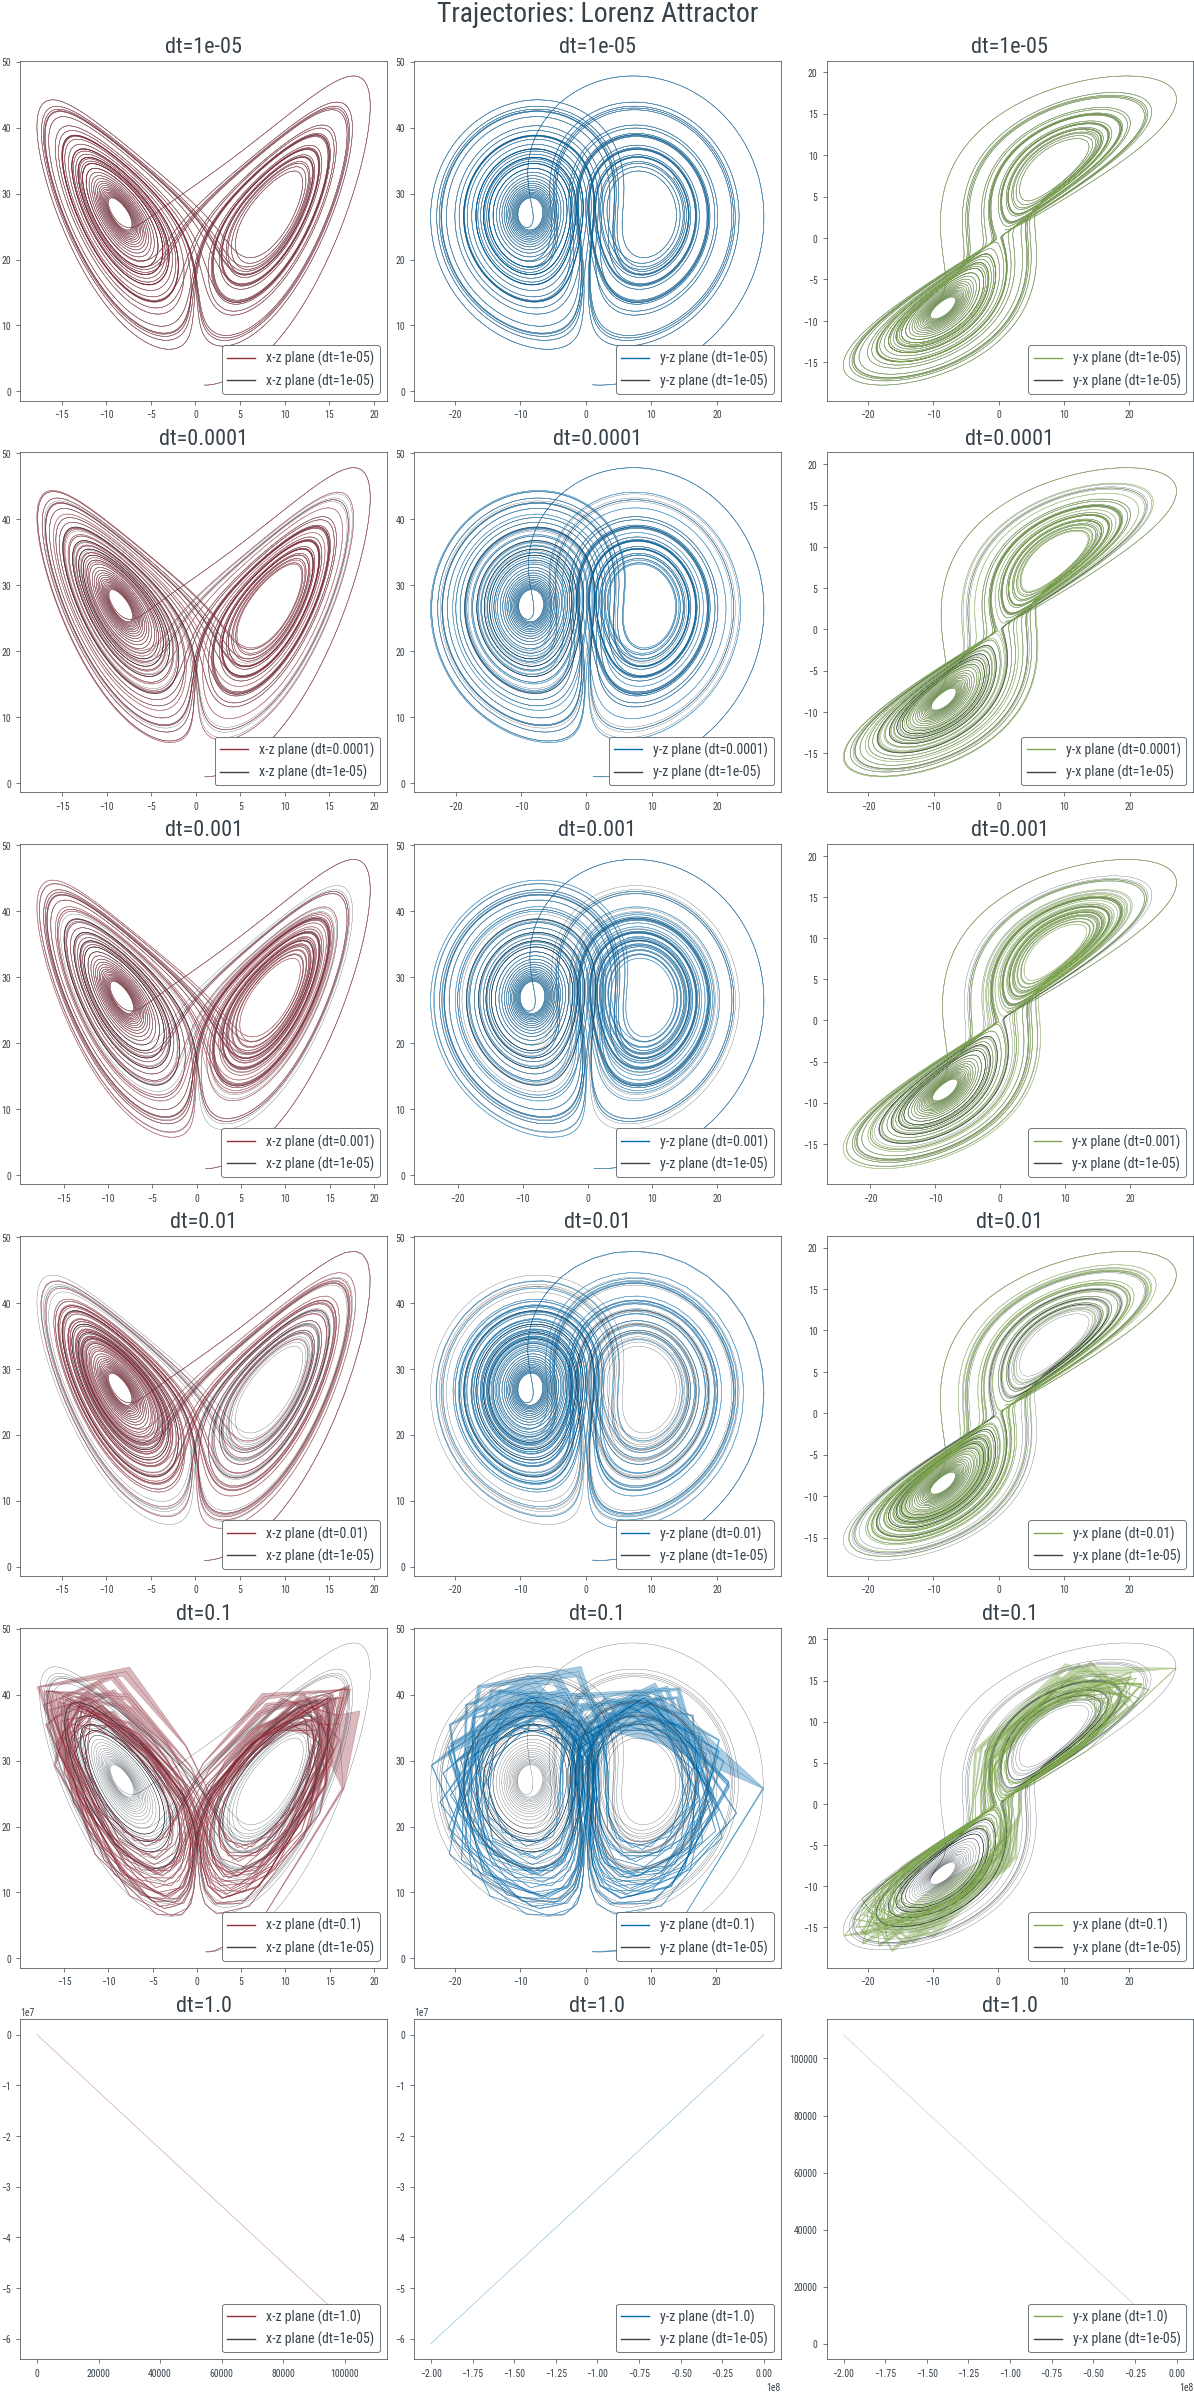

In [27]:
ode_name = "Lorenz Attractor"
r = results[ode_name]
min_dt = min(r.keys())
dts_sorted = sorted(r.keys())
plot_slices = [(0, 2), (1, 2), (1, 0)]

def fn_label(idx):
    map_idx = {0: "x", 1: "y", 2: "z"}
    return f"{map_idx[plot_slices[idx][0]]}-{map_idx[plot_slices[idx][1]]} plane"

fig, axs = plt.subplots(len(r), len(plot_slices), figsize=(len(plot_slices)*4, len(r)*4))
xs_true = jnp.asarray(r[min_dt]["x"])
for row, dt in enumerate(dts_sorted):
    xs, eps = jnp.asarray(r[dt]["x"]), jnp.asarray(r[dt]["eps"])
    for col, (x_idx, y_idx) in enumerate(plot_slices):
        ax = axs[row, col]
        ax.plot(xs_true[:, 0, x_idx], xs_true[:, 0, y_idx], color=color_true, linewidth=0.2)
        ax.plot(xs[:, 0, x_idx], xs[:, 0, y_idx], color=colors_eps[col], linewidth=0.2)
        draw_error_band(ax, xs[:, 0, x_idx], xs[:, 0, y_idx], (eps[:, 0, x_idx]**2 + eps[:, 0, y_idx]**2)**0.5, color=colors_eps[col], alpha=0.33)
        handles = [Line2D([0], [0], label=fn_label(col) + f" (dt={dt})", color=colors_eps[col]),
                    Line2D([0], [0], label=fn_label(col) + f" (dt={min_dt})", color=color_true)]
        ax.set_title(f"dt={dt}", fontsize=16)
        ax.legend(handles=handles, fontsize=10, loc="lower right", facecolor='white', framealpha=1)
fig.suptitle(f"Trajectories: {ode_name}", fontsize=20);

# Adaptive Step Size

## Van-der-Pol Oscillator

In [14]:
ode_name = "Van der Pol Oscillator"
C = 2
r = results[ode_name]
ar = adaptive_results[ode_name]
min_dt = min(r.keys())

def fn_label(idx):
    if idx > 1:
        return f"$d^{idx+1}x(t)/dt^{idx+1}$"
    elif idx == 1:
        return f"$dx(t)/dt$"
    else:
        return f"$x(t)$"

fig, axs = plt.subplots(1, C, figsize=(C*8, 4))
ts_true, xs_true = jnp.asarray(r[min_dt]["t"]), jnp.asarray(r[min_dt]["x"])
ts, xs, eps = jnp.asarray(ar["t"]), jnp.asarray(ar["x"]), jnp.asarray(ar["eps"])
for col in range(C):
    ax = axs[col]
    t_indices = closest_t_indices(ts_true, ts)
    ts_true_cap, xs_true_cap = ts_true[t_indices], xs_true[t_indices]
    delta = jnp.abs(xs_true_cap[:, col, 0] - xs[:, col, 0])
        
    ax.plot(ts, delta, color=color_true, linewidth=0.1)
    ax.plot(ts, eps[:, col, 0], color=colors_eps[col], linewidth=0.5)
    #ax.plot(ts, 1e4*dt**2 * eps[:, col, 0]**0.5, color=colors_eps[col])
    ax.set_yscale("log")
    ax.get_yaxis().set_major_formatter(LogFormatterExponent(base=10, labelOnlyBase=True))
    ax.set_xlabel("$t$")
    ax.set_ylabel("$\\log_{10}(" + fn_label(col).removeprefix("$").removesuffix("$") + ")$")
    
    handles = [Line2D([0], [0], label=fn_label(col) + " (eps)", color=colors_eps[col]),
                Line2D([0], [0], label=fn_label(col) + " (delta)", color=color_true)]
    ax.set_title(f"dt=adaptive", fontsize=16)
    ax.legend(handles=handles, fontsize=12, loc="lower right", facecolor='white', framealpha=1)
fig.suptitle(f"Trajectory Delta + Eps: RKF45: {ode_name}", fontsize=20);

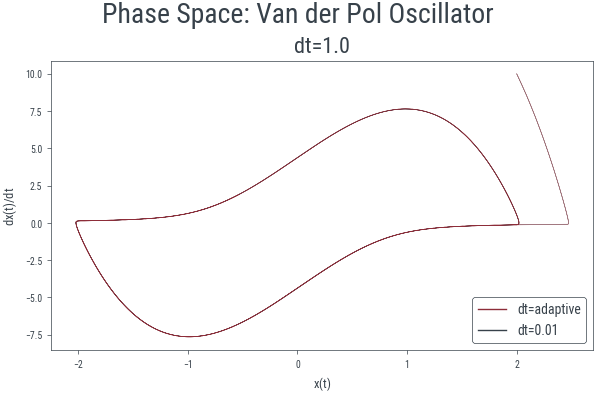

In [29]:
ode_name = "Van der Pol Oscillator"
C = 2
r = results[ode_name]
ar = adaptive_results[ode_name]
min_dt = min(r.keys())

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
xs_true = jnp.asarray(r[min_dt]["x"])
xs, eps = jnp.asarray(ar["x"]), jnp.asarray(ar["eps"])
ax.plot(xs_true[:, 0, 0], xs_true[:, 1, 0], color=color_true, linewidth=0.2)
ax.plot(xs[:, 0, 0], xs[:, 1, 0], color=colors_eps[0], linewidth=0.2)
draw_error_band(ax, xs[:, 0, 0], xs[:, 1, 0], (eps[:, 0, 0]**2 + eps[:, 1, 0]**2)**0.5, color=colors_eps[0], alpha=0.33)
handles = [Line2D([0], [0], label=f"dt=adaptive", color=colors_eps[0]),
            Line2D([0], [0], label=f"dt={min_dt}", color=color_true)]
ax.set_title(f"dt={dt}", fontsize=16)
ax.legend(handles=handles, fontsize=10, loc="lower right", facecolor='white', framealpha=1)
ax.set_xlabel("$x(t)$")
ax.set_ylabel("$dx(t)/dt$")
fig.suptitle(f"Phase Space: {ode_name}", fontsize=20);

## Lorenz Attractor

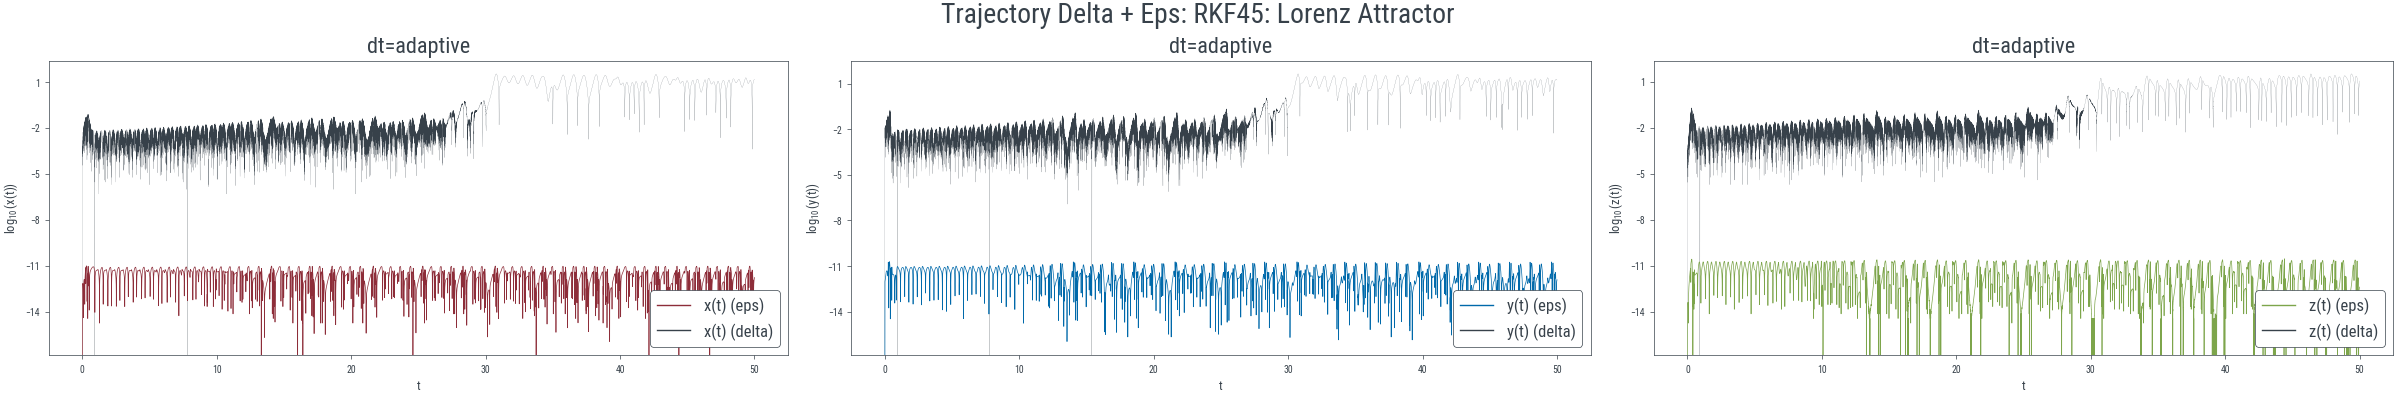

In [15]:
ode_name = "Lorenz Attractor"
C = 3
r = results[ode_name]
ar = adaptive_results[ode_name]
min_dt = min(r.keys())

def fn_label(idx):
    map_idx = {0: "x", 1: "y", 2: "z"}
    return f"{map_idx[idx]}(t)"

fig, axs = plt.subplots(1, C, figsize=(C*8, 4))
ts_true, xs_true = jnp.asarray(r[min_dt]["t"]), jnp.asarray(r[min_dt]["x"])
ts, xs, eps = jnp.asarray(ar["t"]), jnp.asarray(ar["x"]), jnp.asarray(ar["eps"])
for col in range(C):
    ax = axs[col]
    t_indices = closest_t_indices(ts_true, ts)
    ts_true_cap, xs_true_cap = ts_true[t_indices], xs_true[t_indices]
    delta = jnp.abs(xs_true_cap[:, 0, col] - xs[:, 0, col])
        
    ax.plot(ts, delta, color=color_true, linewidth=0.1)
    ax.plot(ts, eps[:, 0, col], color=colors_eps[col], linewidth=0.5)
    #ax.plot(ts, 1e4*dt**2 * eps[:, col, 0]**0.5, color=colors_eps[col])
    ax.set_yscale("log")
    ax.get_yaxis().set_major_formatter(LogFormatterExponent(base=10, labelOnlyBase=True))
    ax.set_xlabel("$t$")
    ax.set_ylabel("$\\log_{10}(" + fn_label(col).removeprefix("$").removesuffix("$") + ")$")
    
    handles = [Line2D([0], [0], label=fn_label(col) + " (eps)", color=colors_eps[col]),
                Line2D([0], [0], label=fn_label(col) + " (delta)", color=color_true)]
    ax.set_title(f"dt=adaptive", fontsize=16)
    ax.legend(handles=handles, fontsize=12, loc="lower right", facecolor='white', framealpha=1)
fig.suptitle(f"Trajectory Delta + Eps: RKF45: {ode_name}", fontsize=20);

In [33]:
ode_name = "Lorenz Attractor"
r = results[ode_name]
ar = adaptive_results[ode_name]
min_dt = min(r.keys())
plot_slices = [(0, 2), (1, 2), (1, 0)]

def fn_label(idx):
    map_idx = {0: "x", 1: "y", 2: "z"}
    return f"{map_idx[plot_slices[idx][0]]}-{map_idx[plot_slices[idx][1]]} plane"

fig, axs = plt.subplots(1, len(plot_slices), figsize=(len(plot_slices)*4, 4))
xs_true = jnp.asarray(r[min_dt]["x"])
xs, eps = jnp.asarray(ar["x"]), jnp.asarray(ar["eps"])
for col, (x_idx, y_idx) in enumerate(plot_slices):
    ax = axs[col]
    ax.plot(xs_true[:, 0, x_idx], xs_true[:, 0, y_idx], color=color_true, linewidth=0.2)
    ax.plot(xs[:, 0, x_idx], xs[:, 0, y_idx], color=colors_eps[col], linewidth=0.2)
    draw_error_band(ax, xs[:, 0, x_idx], xs[:, 0, y_idx], (eps[:, 0, x_idx]**2 + eps[:, 0, y_idx]**2)**0.5, color=colors_eps[col], alpha=0.33)
    handles = [Line2D([0], [0], label=fn_label(col) + f" (dt=adaptive)", color=colors_eps[col]),
                Line2D([0], [0], label=fn_label(col) + f" (dt={min_dt})", color=color_true)]
    ax.set_title(f"dt=adaptive", fontsize=16)
    ax.legend(handles=handles, fontsize=10, loc="lower right", facecolor='white', framealpha=1)
fig.suptitle(f"Trajectories: {ode_name}", fontsize=20);